<a href="https://colab.research.google.com/github/PULI-GOKULA-KISHORE-REDDY/AQI-Project/blob/master/prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

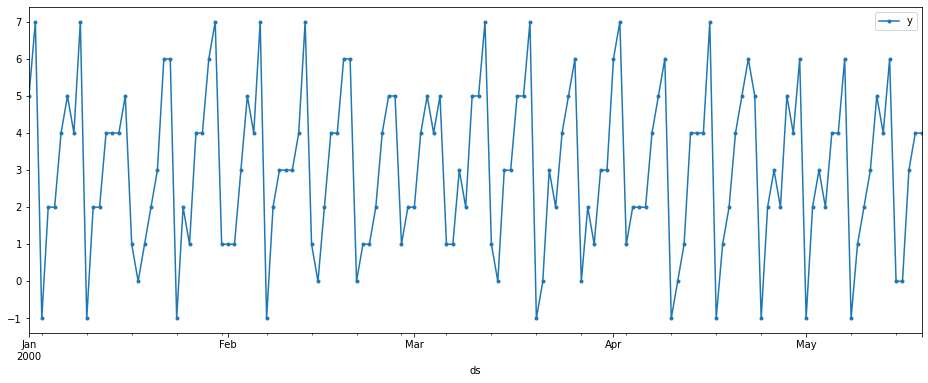

In [ ]:
rng = np.random.RandomState(90)
serie_length = 7 * 20
dates = pd.date_range('2000-01-01', freq='D', periods=serie_length, name='ds')
y = dates.dayofweek + rng.randint(-1, 2, size=dates.size)
data = pd.DataFrame({'y': y.astype(np.float64)}, index=dates)
data.plot(marker='.', figsize=(16, 6));

In [ ]:
data

,y
ds,
2000-01-01,5.0
2000-01-02,7.0
2000-01-03,-1.0
2000-01-04,2.0
2000-01-05,2.0
...,...
2000-05-15,0.0
2000-05-16,0.0
2000-05-17,3.0


In [ ]:
valid_horizon = 14
train = data.head(-valid_horizon).copy()
y_valid = data.tail(valid_horizon)['y']

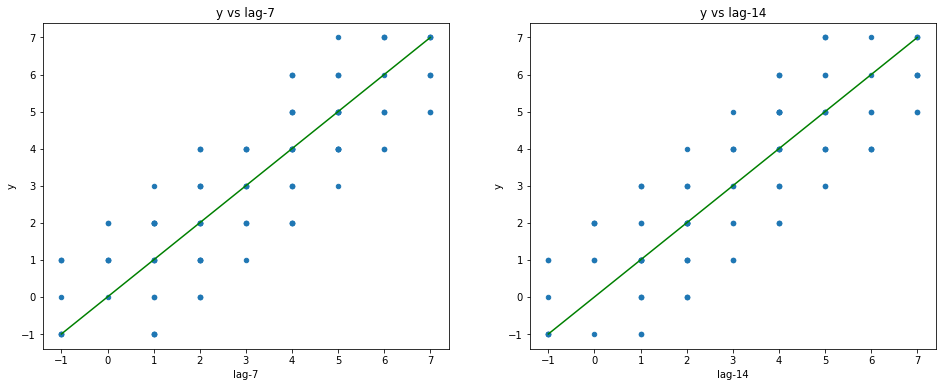

In [ ]:
train['lag-7'] = train['y'].shift(7)
train['lag-14'] = train['y'].shift(14)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

for lag, axi in zip((7, 14), ax.flat):
    train.plot.scatter(x=f'lag-{lag}', y='y', ax=axi)
    axi.plot([-1, 7], [-1, 7], c='g')
    axi.set_title(f'y vs lag-{lag}')

In [ ]:
train

,y,lag-7,lag-14
ds,,,
2000-01-01,5.0,NaN,NaN
2000-01-02,7.0,NaN,NaN
2000-01-03,-1.0,NaN,NaN
2000-01-04,2.0,NaN,NaN
2000-01-05,2.0,NaN,NaN
...,...,...,...
2000-05-01,-1.0,-1.0,-1.0
2000-05-02,2.0,2.0,1.0
2000-05-03,3.0,3.0,2.0


In [ ]:
train.isnull().sum()

y          0
lag-7      7
lag-14    14
dtype: int64

In [ ]:
train_without_nulls = train.dropna()
X_train = train_without_nulls.drop(columns='y')
y_train = train_without_nulls['y']

In [ ]:
lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
lr.coef_

array([0.5136953 , 0.44695162])

In [ ]:
next_lags_7 = y_train.tail(7).values
next_lags_7

array([ 4.,  6., -1.,  2.,  3.,  2.,  4.])

In [ ]:
next_lags_14 = y_train.tail(14).values
next_lags_14

array([ 6.,  5., -1.,  2.,  3.,  2.,  5.,  4.,  6., -1.,  2.,  3.,  2.,
        4.])

In [ ]:
X_valid1 = pd.DataFrame({
    'lag-7': next_lags_7,
    'lag-14': next_lags_14[:7],
})
X_valid1

,lag-7,lag-14
0,4.0,6.0
1,6.0,5.0
2,-1.0,-1.0
3,2.0,2.0
4,3.0,3.0
5,2.0,2.0
6,4.0,5.0


In [ ]:
forecasts_7 = lr.predict(X_valid1)
forecasts_7

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928])

In [ ]:
forecasts_7 = lr.predict(X_valid1)
forecasts_7

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928])

In [ ]:

X_valid2 = pd.DataFrame({
    'lag-7': forecasts_7,
    'lag-14': next_lags_14[-7:],
})
X_valid2

,lag-7,lag-14
0,4.736491,4.0
1,5.316930,6.0
2,-0.960647,-1.0
3,1.921294,2.0
4,2.881941,3.0
5,1.921294,2.0
6,4.289539,4.0


In [ ]:
forecasts_7_14 = lr.predict(X_valid2)
y_pred = np.hstack([forecasts_7, forecasts_7_14])
y_pred

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928,  4.22091958,  5.41299159, -0.94043142,
        1.88086285,  2.82129427,  1.88086285,  3.99132264])

In [ ]:
train_mlfcst = train.reset_index()[['ds', 'y']]
train_mlfcst.index = pd.Index(np.repeat(0, train.shape[0]), name='unique_id')
train_mlfcst.head()

,ds,y
unique_id,,
0,2000-01-01,5.0
0,2000-01-02,7.0
0,2000-01-03,-1.0
0,2000-01-04,2.0
0,2000-01-05,2.0


In [ ]:
from mlforecast.core import TimeSeries
from mlforecast.forecast import Forecast

In [ ]:
!pip install mlforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ts = TimeSeries(lags=[7, 14])
ts

TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=1)

In [ ]:
model = LinearRegression(fit_intercept=False)

In [ ]:
fcst = Forecast(model, ts)
fcst.fit(train_mlfcst)

Forecast(model=LinearRegression(fit_intercept=False), ts=TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=1))

In [ ]:
y_pred_mlfcst = fcst.predict(14)
y_pred_mlfcst

,ds,y_pred
unique_id,,
0,2000-05-06,4.736491
0,2000-05-07,5.316930
0,2000-05-08,-0.960647
0,2000-05-09,1.921294
0,2000-05-10,2.881941
0,2000-05-11,1.921294
0,2000-05-12,4.289539
0,2000-05-13,4.220920
0,2000-05-14,5.412992
